## BG-NBD ve Gamma-Gamma ile CLTV Tahmini

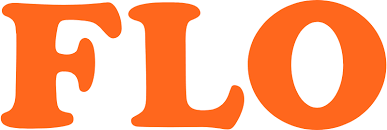

### Data set
#### The dataset consists of information obtained from the past shopping behaviors of customers who made their last purchases from Flo as OmniChannel (both online and offline shopping) in the years 2020-2021.

#### importing libraries

In [2]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

#### Reading Data



In [4]:
df_ = pd.read_csv("flo_data_20k.csv")
df = df_.copy()

#### Quick look at the data


In [5]:
def datareview(dataframe):
    print("******head******")
    print(dataframe.head(10))
    print("******shape******")
    print(dataframe.shape)
    print("******info********")
    print(dataframe.info())
    print("******describe********")
    print(dataframe.describe().T)
    print("***** Nan data********")
    print(dataframe.isnull().sum())

In [6]:
datareview(df)

******head******
                              master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online       interested_in_categories_12
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline       2020-10-30      2021-02-26             2021-02-21              2021-02-26                       4.0000                        1.0000                           139.9900                          799.3800                           [KADIN]
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile       2017-02-08      2021-02-16             2021-02-16              2020-01-10                      19.0000                        2.0000                           159.9700                         1853.5800  [ERKEK, COCUK, KADIN, AKTIFSPOR]
2  69b69676-1a40-11ea-941b-000d3a38a36

####  Outliers handling

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.1109,4.2256,1.0000,1.0000,2.0000,4.0000,200.0000
order_num_total_ever_offline,19945.0000,1.9139,2.0629,1.0000,1.0000,1.0000,2.0000,109.0000
customer_value_total_ever_offline,19945.0000,253.9226,301.5329,10.0000,99.9900,179.9800,319.9700,18119.1400
customer_value_total_ever_online,19945.0000,497.3217,832.6019,12.9900,149.9800,286.4600,578.4400,45220.1300


In [8]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = round(quartile3 + 1.5 * interquantile_range)
    low_limit = round(quartile1 - 1.5 * interquantile_range)
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    #dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    


In [9]:
replace_with_thresholds(df, "order_num_total_ever_online")
replace_with_thresholds(df, "order_num_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_online")

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,2.6886,2.1748,1.0000,1.0000,2.0000,4.0000,8.0000
order_num_total_ever_offline,19945.0000,1.7669,0.9980,1.0000,1.0000,1.0000,2.0000,4.0000
customer_value_total_ever_offline,19945.0000,232.4516,173.9674,10.0000,99.9900,179.9800,319.9700,650.0000
customer_value_total_ever_online,19945.0000,416.8516,352.8910,12.9900,149.9800,286.4600,578.4400,1221.0000


In [11]:
df.describe(percentiles=[.50,.60,.70,.80,.90]).T

,count,mean,std,min,50%,60%,70%,80%,90%,max
order_num_total_ever_online,19945.0000,2.6886,2.1748,1.0000,2.0000,2.0000,3.0000,4.0000,7.0000,8.0000
order_num_total_ever_offline,19945.0000,1.7669,0.9980,1.0000,1.0000,2.0000,2.0000,3.0000,4.0000,4.0000
customer_value_total_ever_offline,19945.0000,232.4516,173.9674,10.0000,179.9800,220.8600,281.8680,365.0580,519.9500,650.0000
customer_value_total_ever_online,19945.0000,416.8516,352.8910,12.9900,286.4600,371.9440,491.5260,690.8680,1082.0360,1221.0000


##### We created new variables for each customer's total purchases and spend


In [12]:
df["total_number_of_purchases"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]

df["total_shopping_fee"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

#### Date type editing


In [13]:
df['last_order_date_offline'] = pd.to_datetime(df['last_order_date_offline'])
df['last_order_date_online'] = pd.to_datetime(df['last_order_date_online'])
df['last_order_date'] = pd.to_datetime(df['last_order_date'])
df['first_order_date'] = pd.to_datetime(df['first_order_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

#### For the recency value, we take 2 days after the last order as the analysis date.


In [14]:
df["last_order_date"].max()

Timestamp('2021-05-30 00:00:00')

#### Date type editing


In [15]:
today_date = dt.datetime(2021, 6, 2)
today_date

datetime.datetime(2021, 6, 2, 0, 0)

In [16]:
cltv_df = pd.DataFrame({"customer_id": df["master_id"],
             "recency_cltv_weekly": ((df["last_order_date"] - df["first_order_date"]).dt.days)/7,
             "T_weekly": ((today_date - df["first_order_date"]).astype('timedelta64[D]'))/7,
             "frequency": df["total_number_of_purchases"],
             "monetary_cltv_avg": df["total_shopping_fee"] / df["total_number_of_purchases"]})

In [17]:
cltv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          19945 non-null  object 
 1   recency_cltv_weekly  19945 non-null  float64
 2   T_weekly             19945 non-null  float64
 3   frequency            19945 non-null  float64
 4   monetary_cltv_avg    19945 non-null  float64
dtypes: float64(4), object(1)
memory usage: 779.2+ KB


#### BG/NBD model

In [18]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [19]:
bgf.fit(cltv_df['frequency'],
       cltv_df['recency_cltv_weekly'],
       cltv_df['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 107.91, b: 0.00, r: 4.69>

In [20]:
cltv_df["exp_sales_3_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(4*3,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency_cltv_weekly'],
                                                        cltv_df['T_weekly'])

In [21]:
cltv_df["exp_sales_6_month"] = bgf.predict(4*6,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])

In [22]:
cltv_df.tail()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41.1429,88.5714,3.0000,133.9867,0.4697,0.9394
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42.2857,65.4286,2.0000,195.2350,0.4632,0.9264
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88.7143,90.0000,3.0000,210.9800,0.4663,0.9326
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98.4286,114.0000,5.0000,189.5960,0.5240,1.0481
19944,740998d2-b1f7-11e9-89fa-000d3a38a36f,39.5714,91.1429,2.0000,130.9850,0.4033,0.8067


#### Gamma-Gamma model 

In [23]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [24]:
ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.16, q: 0.47, v: 4.09>

In [25]:
cltv_df["exp_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                cltv_df['monetary_cltv_avg'])

In [26]:
cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'],
                                       cltv_df['monetary_cltv_avg'],
                                       time=6,  # 6 aylık
                                       freq="W",  # T'nin frekans bilgisi.
                                       discount_rate=0.01)

In [27]:
cltv_df["cltv"] = cltv

In [28]:
cltv_df.sort_values("cltv",ascending=False)[:5]


,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_profit,cltv
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,9.5714,2.0000,650.2450,0.6834,1.3668,696.4502,998.7648
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,8.0000,4.0000,467.7500,0.8997,1.7994,484.1208,914.0228
15123,635b5e0a-a686-11eb-a6d3-000d3a299ebf,2.0000,5.2857,3.0000,447.1100,0.8153,1.6306,468.2676,801.1237
10792,f1f89712-84e5-11eb-8a3c-000d3a38a36f,7.2857,11.4286,2.0000,522.4500,0.6728,1.3455,560.0032,790.5918
7173,8897f4a8-c793-11ea-b753-000d3a38a36f,40.1429,45.8571,3.0000,597.1433,0.6002,1.2004,624.9232,787.0498


In [29]:
cltv_df["cltv_segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])

In [30]:
cltv_df.head(1)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_profit,cltv,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.7143,5.0000,187.8740,0.8389,1.6777,193.6020,340.7980,A


####  Action review

In [31]:
cltv_df.groupby("cltv_segment").agg({"count","mean","sum"})

recency_cltv_weekly                   T_weekly                 frequency              monetary_cltv_avg                exp_sales_3_month              exp_sales_6_month              exp_average_profit                        cltv               
                             sum     mean count         sum     mean count        sum   mean count               sum     mean count               sum   mean count               sum   mean count                sum     mean count          sum     mean count
cltv_segment                                                                                                                                                                                                                                                   
D                    691817.8571 138.7243  4987 807751.4286 161.9714  4987 18656.0000 3.7409  4987       460724.3270  92.3851  4987         2017.3505 0.4045  4987         4034.7009 0.8090  4987        487706.9407  97.7957  4987  396222.7512  79.4511  4987
C                    502597.4286 100.8017  4986 602295.1429 120.7973  4986 21728.0000 4.3578  4986       632976.5582 126.9508  4986         2445.3933 0.4905  4986         4890.7867 0.9809  4986        664292.4610 133.2315  4986  657142.7351 131.7976  4986
B                    408637.8571  81.9571  4986 501581.8571 100.5980  4986 23634.0000 4.7401  4986       790299.8440 158.5038  4986         2741.7784 0.5499  4986         5483.5568 1.0998  4986        825901.0638 165.6440  4986  916867.5985 183.8884  4986
A                    296977.2857  59.5622  4986 374361.5714  75.0825  4986 24848.0000 4.9836  4986      1090446.5257 218.7017  4986         3198.8211 0.6416  4986         6397.6421 1.2831  4986       1138510.9241 228.3415  4986 1457499.1077 292.3183  4986